In [3]:
%pip install mlxtend
%pip install prettytable

In [4]:
import pandas as pd
import numpy as np 
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from math import sqrt
import statsmodels.api as sm
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from prettytable import PrettyTable
import time 
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors
import matplotlib.patches as patches

In [5]:
from sklearn.datasets import load_boston
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

import warnings; warnings.simplefilter('ignore')

In [95]:
path = os.getcwd()
path

'C:\\Users\\venu\\Desktop\\Stock Market Analysis'

# Pre-processing the Data

In [96]:
def pre_process_data(data,null_threshold):
    data.drop(columns=['Unixtime','Date'],axis=1,inplace=True)
    total = data.shape[0]
    for col in data.columns:
        if null_threshold * total / 100 <= data[col].isnull().sum():
            data.drop(columns=[col],axis=1,inplace=True)
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.dropna(axis=0,inplace=True)
    return data

# Removing columns based on the dependent column

In [97]:
def dependent_column(data,column):
    cols = [col for col in data.columns if "next" not in col.lower()]
    cols.append(column)
    data = data[cols]
    return (data,column)

# OLS Regression

In [98]:
def OLS_Regression(X_train,Y_train):
    X_train = np.array(X_train, dtype=float)
    ols_model = sm.OLS(Y_train, X_train).fit()
    
    rsquared_adj = ols_model.rsquared_adj
    aic = ols_model.aic
    bic = ols_model.bic
    fvalue = ols_model.fvalue
    return {"rsquared_adj":rsquared_adj,"aic":aic,"bic":bic,"fvalue":fvalue}

# Linear Regression

In [99]:
def linear_regression(data,y):
#     print("------ Linear Regression ------")
    X = data[data.columns[:-1]]
    Y = data[y].values
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
    model = LinearRegression(fit_intercept = True)  
    model.fit(X_train, Y_train)
    pred = model.predict(X_test)

    confidence = model.score(X_test, Y_test)
    rmse = sqrt(metrics.mean_squared_error(Y_test, pred))
    mae = metrics.mean_absolute_error(Y_test, pred)
    mse = metrics.mean_squared_error(Y_test, pred)
    ols_values = OLS_Regression(X_train,Y_train)
    return {"root_mean_squared_error":rmse,"mean_absolute_error":mae,"mean_squared_error":mse,"OLS":ols_values}

# Linear Regression with Forward Selection

In [100]:
def forward_selection(data, target, significance_level=0.05):
    initial_features = data.columns.tolist()
    best_features = []
    while (len(initial_features)>0):
        remaining_features = list(set(initial_features)-set(best_features))
        new_pval = pd.Series(index=remaining_features)
        for new_column in remaining_features:
            model = sm.OLS(target, sm.add_constant(data[best_features+[new_column]]).astype(float)).fit()
            new_pval[new_column] = model.pvalues[new_column]
        min_p_value = new_pval.min()
        if(min_p_value<significance_level):
            best_features.append(new_pval.idxmin())
        else:
            break
    return best_features

In [101]:
def linear_regression_forward_selection(data,y):
#     print("------ Linear Regression Forward Selection ------")
    X = data[data.columns[:-1]]
    Y = data[y].values
    forward_features = forward_selection(X,Y)
#     print(forward_features)
    return linear_regression(data[forward_features+[y]],y)

# Linear Regression with Backward Elimination

In [102]:
def backward_elimination(data, target,significance_level = 0.05):
    features = data.columns.tolist()
    while(len(features)>0):
        features_with_constant = sm.add_constant(data[features]).astype(float)
        p_values = sm.OLS(target, features_with_constant).fit().pvalues[1:]
        max_p_value = p_values.max()
        if(max_p_value >= significance_level):
            excluded_feature = p_values.idxmax()
            features.remove(excluded_feature)
        else:
            break 
    return features

In [103]:
def linear_regression_backward_selection(data,y):
#     print("------ Linear Regression Backward Selection ------")
    X = data[data.columns[:-1]]
    Y = data[y].values
    backward_features = backward_elimination(X,Y)
    print(backward_features)
    return linear_regression(data[backward_features+[y]],y)

# Using in-built forward selection method

In [104]:
def forward_selection_inbuilt(X,Y,k,score):
    sfs = SFS(LinearRegression(),k_features=k,forward=True,floating=False,scoring = score,cv = 0)
    sfs.fit(X, Y)
    lst = list(sfs.k_feature_names_)
    return lst

In [105]:
def linear_regression_forward_selection_inbuit(data,y):
#     print("------ Linear Regression Forward Selection Inbuilt ------")

    X = data[data.columns[:-1]]
    Y = data[y].values
    scores = ['explained_variance','max_error','neg_mean_absolute_error','neg_mean_squared_error',
                  'neg_root_mean_squared_error','neg_median_absolute_error','r2']
    df = pd.DataFrame(columns=scores,index=range(1,data.shape[1]+1))
    for k in range(1,data.shape[1]+1):
        for score in scores:
            sfs = forward_selection_inbuilt(X,Y,k,score)
            df.loc[k,score] = sfs
    df.to_csv("forwardFeatures.csv",index=None)
    return df

# Using in-built backward elimination method

In [106]:
def backward_selection_inbuilt(X,Y,k,score):
    sfs = SFS(LinearRegression(),k_features=k,forward=False,floating=False,scoring = score,cv = 0)
    sfs.fit(X, Y)
    lst = list(sfs.k_feature_names_)
    return lst

In [107]:
def linear_regression_backward_selection_inbuit(data,y):
#     print("------ Linear Regression Backward Selection Inbuilt ------")
    X = data[data.columns[:-1]]
    Y = data[y].values
    scores = ['explained_variance','max_error','neg_mean_absolute_error','neg_mean_squared_error',
                  'neg_root_mean_squared_error','neg_median_absolute_error','r2']
    df = pd.DataFrame(columns=scores,index=range(1,data.shape[1]+1))
    for k in range(1,data.shape[1]+1):
        for score in scores:
            sfs = backward_selection_inbuilt(X,Y,k,score)
            df.loc[k,score] = sfs
    df.to_csv("backwardFeatures.csv",index=None)
    return df

# Ridge Regression

In [108]:
def bestparams_ridge(alpha,X_train,Y_train):
    
    ridge = Ridge(alpha=1).fit(X_train,Y_train)
    param_grid = dict(alpha=alpha)
    grid = GridSearchCV(estimator=ridge, param_grid=param_grid, scoring='r2')
    grid.fit(X_train,Y_train)
    alpha_val = grid.best_estimator_.alpha
    return alpha_val

In [109]:
def ridge_regression(data,y):
    
#     print("------ Ridge Regression ------")

    X = data[data.columns[:-1]]
    Y = data[y].values
    
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
    
    # selection of alpha value from the respective array values
    alpha = np.array([1,0.1,0.01,0.001,0.0001,0])
    best = bestparams_ridge(alpha,X_train,Y_train)
    print("Best Alpha:", best) # best alpha value
    
    # Re-selecting the alpha value based on the above selected alpha value
    alpha1 = np.arange(best-10,best+10)
    best_alpha = bestparams_ridge(alpha1,X_train,Y_train)
    print("Best Alpha after tuning : ", best_alpha)
    # Ridge regression with the above best alpha value and the train datasets.
    clf = Ridge(alpha=best_alpha)
    clf.fit(X_train, Y_train)
    
    pred = clf.predict(X_test)
    
    confidence = clf.score(X_test, Y_test)
    rmse = sqrt(metrics.mean_squared_error(Y_test, pred))
    mae = metrics.mean_absolute_error(Y_test, pred)
    mse = metrics.mean_squared_error(Y_test, pred)

    ols_values = OLS_Regression(X_train,Y_train)

    return {"root_mean_squared_error":rmse,"mean_absolute_error":mae,"mean_squared_error":mse,"OLS":ols_values}

# Lasso Regression

In [110]:
def bestparams_lasso(alpha,X_train,Y_train):
    
    lasso = Lasso(alpha=1).fit(X_train,Y_train)
    param_grid = dict(alpha=alpha)
    grid = GridSearchCV(estimator=lasso, param_grid=param_grid, scoring='r2')
    grid.fit(X_train,Y_train)
    alpha_val = grid.best_estimator_.alpha
    return alpha_val

In [111]:
def lasso_regression(data,y):
    
#     print("------ Lasso Regression ------")

    X = data[data.columns[:-1]]
    Y = data[y].values
    
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
    
    # selection of alpha value from the respective array values
    alpha = np.array([1,0.1,0.01,0.001,0.0001,0])
    best = bestparams_lasso(alpha,X_train,Y_train)
#     print("Best Alpha:", best) # best alpha value
    
    # Re-selecting the alpha value based on the above selected alpha value
    alpha1 = np.arange(best-10,best+10)
    best_alpha = bestparams_lasso(alpha1,X_train,Y_train)
#     print("Best Alpha after tuning : ", best_alpha)
    # Lasso regression with the above best alpha value and the train datasets.
    clf = Lasso(alpha=best_alpha)
    clf.fit(X_train, Y_train)
    
    pred = clf.predict(X_test)
    
    confidence = clf.score(X_test, Y_test)
    rmse = sqrt(metrics.mean_squared_error(Y_test, pred))
    mae = metrics.mean_absolute_error(Y_test, pred)
    mse = metrics.mean_squared_error(Y_test, pred)
    ols_values = OLS_Regression(X_train,Y_train)

    return {"root_mean_squared_error":rmse,"mean_absolute_error":mae,"mean_squared_error":mse,"OLS":ols_values}

# Elastic Regression

In [112]:
def bestparams_elastic(alphas,l1,X_train,Y_train):
    
    elastic_net = ElasticNet(alpha=1, l1_ratio=0.2).fit(X_train, Y_train)
    param_grid = dict(alpha=alphas, l1_ratio=l1)
    grid = GridSearchCV(estimator=elastic_net, param_grid=param_grid, scoring='r2')
    grid_result = grid.fit(X_train, Y_train)
    alpha_val = grid_result.best_estimator_.alpha
    l1_val = grid_result.best_estimator_.l1_ratio
    return (alpha_val,l1_val)

In [113]:
def elastic_net_regression(data,y):

#     print("------ Elastic Net Regression ------")
    
    X = data[data.columns[:-1]]
    Y = data[y].values
    
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
    
    # selection of alpha value from the respective array values
    
    alpha = np.array([0,0.1,0.001,0.0001,1])
    l1_ratio = np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
    
    best = bestparams_elastic(alpha,l1_ratio,X_train,Y_train)
#     print("Best Alpha:", best[0]) # best alpha value
#     print("Best l1 - value:", best[1])
    
    # Re-selecting the alpha value based on the above selected alpha value
    
    alpha1 = np.arange(best[0]/10,best[0]*10)
    best_alpha = bestparams_elastic(alpha1,l1_ratio,X_train,Y_train)
#     print("Best Alpha after tuning : ", best_alpha[0])
#     print("Best l1 after tuning : ", best_alpha[1])
    clf = ElasticNet(alpha=best_alpha[0],l1_ratio = best_alpha[1])
    clf.fit(X_train, Y_train)
    
    pred = clf.predict(X_test)
    
    confidence = clf.score(X_test, Y_test)
    
    rmse = sqrt(metrics.mean_squared_error(Y_test, pred))
    mae = metrics.mean_absolute_error(Y_test, pred)
    mse = metrics.mean_squared_error(Y_test, pred)
    ols_values = OLS_Regression(X_train,Y_train)
    
    # coeff_vs_Regularization(X_train,Y_train)

    return {"root_mean_squared_error":rmse,"mean_absolute_error":mae,"mean_squared_error":mse,"OLS":ols_values}

In [114]:
def coeff_vs_Regularization(X_train,Y_train):
    coefs = []
    n_alphas = 200
    alphas = np.logspace(-10, -2, n_alphas)

    for a in alphas:
        elastic = ElasticNet(alpha=a)
        elastic.fit(X_train, Y_train)
        coefs.append(elastic.coef_)
    
    ax = plt.gca()

    ax.plot(alphas, coefs)
    ax.set_xscale('log')
    ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
    plt.xlabel('alpha(log scale)')
    plt.ylabel('Coefficients')
    plt.title('ElasticNet - Coefficients Vs Regularization')
    plt.axis('tight')
    plt.show()

# Pretty Table

In [1]:
columns = ["company",'root_mean_squared_error', 'mean_absolute_error', 'mean_squared_error','rsquared_adj', 'aic', 'bic', 'fvalue']

In [6]:
models = ["linear_regression","linear_regression_forward_selection","linear_regression_backward_selection","lasso_regression","ridge_regression","elastic_net_regression"]
tables = {model:PrettyTable() for model in models}
for name,table in tables.items():
    table.field_names = columns

In [117]:
def create_pretty_table(filename,model,result):
    values = [filename] + [v for k,v in result.items() if not isinstance(v,dict)] + list(result["OLS"].values())
    tables[model].add_row(values)
    tables[model].title = model

In [118]:
%%time
for filename in os.listdir(os.path.join(path,"Data/Stock")):
    if filename.startswith("mod") and filename.endswith("GR.csv"):
        print(filename)
        start = time.time()
        df = pd.read_csv(os.path.join(path,"Data\Stock\\"+filename))
        df = pre_process_data(df,60)
#         print(df)
        column = "Next Day Close Price GR"
        (data,column) = dependent_column(df,column)
#         print(df)
        result = linear_regression(data,column)
        create_pretty_table(filename,linear_regression.__name__,result)
        result = linear_regression_forward_selection(data,column)
        create_pretty_table(filename,linear_regression_forward_selection.__name__,result)
        result = linear_regression_backward_selection(data,column)
        create_pretty_table(filename,linear_regression_backward_selection.__name__,result)
        result = ridge_regression(data,column)
        create_pretty_table(filename,ridge_regression.__name__,result)
        result = lasso_regression(data,column)
        create_pretty_table(filename,lasso_regression.__name__,result)
        result = elastic_net_regression(data,column)
        create_pretty_table(filename,elastic_net_regression.__name__,result)
        end = time.time()
        print(os.path.splitext(filename)[0],end-start)


mod500112GR.csv
['Low Price', '% Return of Company', '% YTD of Company', 'Revenue', 'Income', 'Expenditure', 'Net Profit', 'EPS', 'Revenue last 2 quarters', 'Net Profit  last 2 quarters', 'Expenditure  last 4 quarters', 'Net Profit  last 4 quarters', 'EPS last 4 quarters', 'Revenue last 8 quarters', 'Income last 8 quarters', 'Expenditure  last 8 quarters', 'Net Profit  last 8 quarters', 'Close Price GR', 'No.of Shares GR', 'Total Turnover (Rs.) GR', 'Sequential Increase', 'Sequential Decrease', 'Sequential Decrease %', 'Max Inc % in 90 days', 'Min Dec % in 90 days', 'CP % HV 7 days', 'CP % HV 30 days', 'CP % LV 90 days', 'CP % HV 90 days', 'CP % BA 90 days', 'CP % HV 180 days', 'CP % BA 365 days']
Best Alpha: 1.0
Best Alpha after tuning :  10.0
mod500112GR 88.44728231430054
mod500180GR.csv
['Open Price', 'High Price', '% YTD of Company', 'EPS', 'p/e', 'Spread Close-Open GR', 'Sequential Increase', 'Sequential Decrease', 'Sequential Decrease %']
Best Alpha: 0.001
Best Alpha after tuning

In [119]:
for name,table in tables.items():
    print(table)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|                                                                               linear_regression                                                                                |
+-----------------+-------------------------+----------------------+------------------------+---------------------+--------------------+--------------------+--------------------+
|     company     | root_mean_squared_error | mean_absolute_error  |   mean_squared_error   |     rsquared_adj    |        aic         |        bic         |       fvalue       |
+-----------------+-------------------------+----------------------+------------------------+---------------------+--------------------+--------------------+--------------------+
| mod500112GR.csv |   0.027982746215301734  | 0.01519599924697365  | 0.0007830340857499834  | 0.270160696

In [120]:
features = {}

In [121]:
%%time
for filename in os.listdir(os.path.join(path,"Data/Stock")):
    if filename.startswith("mod") and filename.endswith("GR.csv"):
        start = time.time()
        df = pd.read_csv(os.path.join(path,"Data\Stock\\"+filename))
        df = pre_process_data(df,60)
        column = "Next Day Close Price GR"
        (data,column) = dependent_column(df,column)
        X = data[data.columns[:-1]]
        Y = data[column].values
        forward_features = forward_selection(X,Y)
        backward_features = backward_elimination(X,Y)
        feat = {"forward_features":forward_features,"backward_features":backward_features}
        end = time.time()
        name = os.path.splitext(filename)[0]
        features[name] = features.get(name,{})
        features[name].update(feat)
        end = time.time()
        print(name,end-start)

mod500112GR 10.33669114112854
mod500180GR 8.33919382095337
mod500182GR 10.767467737197876
mod500209GR 17.827553272247314
mod500325GR 10.998468160629272
mod507685GR 17.26689839363098
mod530965GR 16.2014479637146
mod532174GR 12.015902757644653
mod532210GR 19.61030888557434
mod532540GR 6.5610151290893555
Wall time: 2min 9s


In [122]:
for name,feature in features.items():
    print(name)
    print("forward_features",feature["forward_features"])
    print("backward_features",feature["backward_features"])
    print("---------------------------")

mod500112GR
forward_features ['Sequential Decrease', 'Sequential Increase', 'Sequential Decrease %', 'Spread Close-Open', 'Min Dec % in 90 days', 'CP % HV 90 days', 'Max Inc % in 90 days', 'Low Price', 'CP % LV 90 days', 'CP % LV 180 days', 'Sequential Increase %', 'Close Price']
backward_features ['Low Price', '% Return of Company', '% YTD of Company', 'Revenue', 'Income', 'Expenditure', 'Net Profit', 'EPS', 'Revenue last 2 quarters', 'Net Profit  last 2 quarters', 'Expenditure  last 4 quarters', 'Net Profit  last 4 quarters', 'EPS last 4 quarters', 'Revenue last 8 quarters', 'Income last 8 quarters', 'Expenditure  last 8 quarters', 'Net Profit  last 8 quarters', 'Close Price GR', 'No.of Shares GR', 'Total Turnover (Rs.) GR', 'Sequential Increase', 'Sequential Decrease', 'Sequential Decrease %', 'Max Inc % in 90 days', 'Min Dec % in 90 days', 'CP % HV 7 days', 'CP % HV 30 days', 'CP % LV 90 days', 'CP % HV 90 days', 'CP % BA 90 days', 'CP % HV 180 days', 'CP % BA 365 days']
----------

# Feature Importance

In [123]:
mycols = ["company",'Open Price', 'High Price', 'Low Price','WAP','No.of Shares', 'No. of Trades', 'Total Turnover (Rs.)',
       'Deliverable Quantity', '% Deli. Qty to Traded Qty', 'Spread High-Low','Spread Close-Open']
feature_importance = pd.DataFrame(columns=mycols)

In [124]:
%%time
for filename in os.listdir(os.path.join(path,"Data/Stock")):
    if filename.startswith("mod") and filename.endswith("GR.csv"):
        print(filename)
        start = time.time()
        df = pd.read_csv(os.path.join(path,"Data\Stock\\" + filename))
        df = pre_process_data(df,60)
#         print(df)
        name = os.path.splitext(filename)[0]
        cols = ['Open Price', 'High Price', 'Low Price','WAP','No.of Shares', 'No. of Trades', 'Total Turnover (Rs.)',
       'Deliverable Quantity', '% Deli. Qty to Traded Qty', 'Spread High-Low','Spread Close-Open']
#         cols = df.columns
        depd = "Close Price"
        X = df[cols]
        Y = df[depd]
        model = LinearRegression(fit_intercept=True)
        model.fit(X, Y)
        data = [name] + [round(i,6) for i in list(model.coef_)]
#         feature_importance = pd.DataFrame(columns=cols)
        feature_importance.loc[feature_importance.shape[0]] = data
#         importance = model.coef_
#         for i,v in enumerate(importance):
#             print("Feature : " , i)
#             print("Score : ", v)

mod500112GR.csv
mod500180GR.csv
mod500182GR.csv
mod500209GR.csv
mod500325GR.csv
mod507685GR.csv
mod530965GR.csv
mod532174GR.csv
mod532210GR.csv
mod532540GR.csv
Wall time: 1.53 s


In [125]:
feature_importance

,company,Open Price,High Price,Low Price,WAP,No.of Shares,No. of Trades,Total Turnover (Rs.),Deliverable Quantity,% Deli. Qty to Traded Qty,Spread High-Low,Spread Close-Open
0,mod500112GR,1.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,1.0
1,mod500180GR,1.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,1.0
2,mod500182GR,1.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,1.0
3,mod500209GR,1.0,0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,1.0
4,mod500325GR,1.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,1.0
5,mod507685GR,1.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,1.0
6,mod530965GR,1.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,1.0
7,mod532174GR,1.0,-0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,1.0
8,mod532210GR,1.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,1.0
9,mod532540GR,1.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,1.0


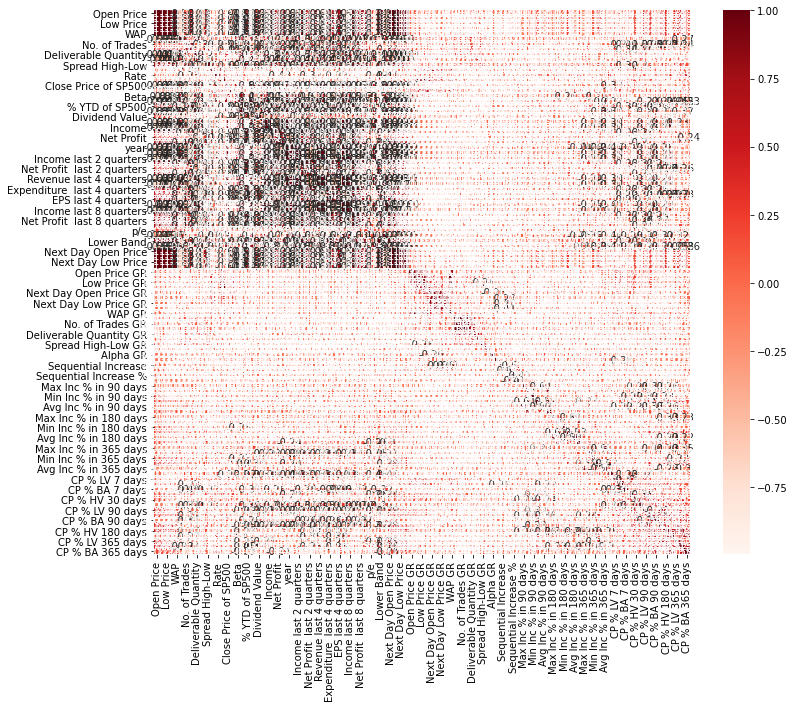

[0.99920457 0.99967134 0.99964604 1.         0.99985353 0.5559458
 0.63622607 0.64092051 0.80135756 0.91122186 0.84742093 0.68766216
 0.71218369 0.67958187 0.7651291  0.66840187 0.6797946  0.70577975
 0.67952323 0.68350671 0.67794719 0.70700354 0.69661256 0.51629696
 0.74111997 0.69168514 0.71354553 0.72409272 0.69410896 0.77219695
 0.81260433 0.55590216 0.99839715 0.99808719 0.99799919 0.99766704]
Wall time: 41.9 s


In [128]:
%%time
for filename in os.listdir(os.path.join(path, "Data/Stock")):
    if (filename.startswith("mod") and filename.endswith("GR.csv")):
        df = pd.read_csv(os.path.join(path, "Data\Stock\\" + filename))
        df = pre_process_data(df, 60)
        Y = df["Close Price"]
        X = df.drop(["Close Price"], 1)
        
        #Using Pearson Correlation
        plt.figure(figsize=(12,10))
        cor = df.corr()
        sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
        plt.show()
        
        #Correlation with output variable
        cor_target = abs(cor["Close Price"])
        #Selecting highly correlated features
        relevant_features = cor_target[cor_target > 0.5]
        print(relevant_features.values)
        break